In [2]:
import numpy as np 
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import xgboost
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
import chardet
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

from IPython.display import clear_output
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
# Import data from csv and create a database (including table) and a dataframe.

Path('maternity_risk_data.db').touch()
#con = sqlite3.connect("/kaggle/working/maternity_risk_data.db")
con = sqlite3.connect("maternity_risk_data.db")
cur = con.cursor()
cur.execute('''CREATE TABLE IF NOT EXISTS risk_tb (Age, SystolicBP, DiastolicBP, BS, BodyTemp, HeartRate, RiskLevel)''')
df = pd.read_csv('Maternal Health Risk Data Set.csv')
index = [i + 1 for i in df.index]
df.insert(1, 'index_col', index) # Add a column for index since it was missing from original dataset. 
df.to_sql('risk_tb', con, if_exists='replace', index=False)
pregnancy_risk = pd.read_sql('''SELECT * FROM risk_tb''',con)
pregnancy_risk

,Age,index_col,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,1,130,80,15.0,98.0,86,high risk
1,35,2,140,90,13.0,98.0,70,high risk
2,29,3,90,70,8.0,100.0,80,high risk
3,30,4,140,85,7.0,98.0,70,high risk
4,35,5,120,60,6.1,98.0,76,low risk
...,...,...,...,...,...,...,...,...
1009,22,1010,120,60,15.0,98.0,80,high risk
1010,55,1011,120,90,18.0,98.0,60,high risk
1011,35,1012,85,60,19.0,98.0,86,high risk
1012,43,1013,120,90,18.0,98.0,70,high risk


In [3]:
"""
Cell generated by Data Wrangler.
"""
def clean_data(pregnancy_risk):
    # Drop column: 'index_col'
    pregnancy_risk = pregnancy_risk.drop(columns=['index_col'])
    return pregnancy_risk

pregnancy_risk_clean = clean_data(pregnancy_risk.copy())
pregnancy_risk_clean.head() 

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk


In [4]:
# View the first few rows of the DataFrame
print(pregnancy_risk_clean.head())

# Summary statistics for numerical columns
print(pregnancy_risk_clean.describe())

# Information on the DataFrame including the data types of each column
print(pregnancy_risk_clean.info())


   Age  SystolicBP  DiastolicBP    BS  BodyTemp  HeartRate  RiskLevel
0   25         130           80  15.0      98.0         86  high risk
1   35         140           90  13.0      98.0         70  high risk
2   29          90           70   8.0     100.0         80  high risk
3   30         140           85   7.0      98.0         70  high risk
4   35         120           60   6.1      98.0         76   low risk
               Age   SystolicBP  DiastolicBP           BS     BodyTemp  \
count  1014.000000  1014.000000  1014.000000  1014.000000  1014.000000   
mean     29.871795   113.198225    76.460552     8.725986    98.665089   
std      13.474386    18.403913    13.885796     3.293532     1.371384   
min      10.000000    70.000000    49.000000     6.000000    98.000000   
25%      19.000000   100.000000    65.000000     6.900000    98.000000   
50%      26.000000   120.000000    80.000000     7.500000    98.000000   
75%      39.000000   120.000000    90.000000     8.000000    9

In [5]:
pregnancy_risk_clean

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk
...,...,...,...,...,...,...,...
1009,22,120,60,15.0,98.0,80,high risk
1010,55,120,90,18.0,98.0,60,high risk
1011,35,85,60,19.0,98.0,86,high risk
1012,43,120,90,18.0,98.0,70,high risk


In [6]:
pregnancy_risk_clean.columns

Index(['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate',
       'RiskLevel'],
      dtype='object')

In [7]:
risk = pregnancy_risk_clean.copy()

In [8]:
# For numerical columns
for col in risk.select_dtypes(include=['float64', 'int64']):
    risk[col].fillna(risk[col].mean(), inplace=True)

# For categorical columns
for col in risk.select_dtypes(include=['object']):
    risk[col].fillna(risk[col].mode()[0], inplace=True)


In [9]:
risk

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk
...,...,...,...,...,...,...,...
1009,22,120,60,15.0,98.0,80,high risk
1010,55,120,90,18.0,98.0,60,high risk
1011,35,85,60,19.0,98.0,86,high risk
1012,43,120,90,18.0,98.0,70,high risk


In [10]:
# Define a mapping from risk level to number
risk_mapping = {"high risk": 3, "mid risk": 2, "low risk": 1}

# Replace the risk level categories with numbers
risk["RiskScore"] = risk["RiskLevel"].replace(risk_mapping)


In [11]:
risk

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel,RiskScore
0,25,130,80,15.0,98.0,86,high risk,3
1,35,140,90,13.0,98.0,70,high risk,3
2,29,90,70,8.0,100.0,80,high risk,3
3,30,140,85,7.0,98.0,70,high risk,3
4,35,120,60,6.1,98.0,76,low risk,1
...,...,...,...,...,...,...,...,...
1009,22,120,60,15.0,98.0,80,high risk,3
1010,55,120,90,18.0,98.0,60,high risk,3
1011,35,85,60,19.0,98.0,86,high risk,3
1012,43,120,90,18.0,98.0,70,high risk,3


In [12]:
# # One hot encoding by pandas
# ohe=pd.get_dummies(risk, drop_first=False)

In [13]:
dummies = pd.get_dummies(pregnancy_risk_clean)
print(dummies.columns)

from sklearn.model_selection import train_test_split

# Set age as feature
X=dummies.drop(['RiskLevel_high risk', 'RiskLevel_low risk', 'RiskLevel_low risk'], axis=1)
y=dummies[['RiskLevel_high risk', 'RiskLevel_low risk', 'RiskLevel_low risk']]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Index(['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate',
       'RiskLevel_high risk', 'RiskLevel_low risk', 'RiskLevel_mid risk'],
      dtype='object')


In [14]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the features
X = scaler.fit_transform(X)


In [15]:
from sklearn.model_selection import train_test_split

# Split the data, let's use 80% for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [16]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize base classifier
base_classifier = LogisticRegression(max_iter=10000)

# Initialize the multi-output classifier
model = MultiOutputClassifier(base_classifier)

# Train the model
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Generate classification report for each output
for i in range(y_test.shape[1]):
    print(f"Classification report for output {y_test.columns[i]}:")
    print(classification_report(y_test.iloc[:, i], y_pred[:, i]))


Classification report for output RiskLevel_high risk:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       156
           1       0.89      0.83      0.86        47

    accuracy                           0.94       203
   macro avg       0.92      0.90      0.91       203
weighted avg       0.94      0.94      0.94       203

Classification report for output RiskLevel_low risk:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       123
           1       0.88      0.94      0.91        80

    accuracy                           0.93       203
   macro avg       0.92      0.93      0.92       203
weighted avg       0.93      0.93      0.93       203

Classification report for output RiskLevel_low risk:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       123
           1       0.88      0.94      0.91        80

    accuracy          

c:\ProgramData\Anaconda3\envs\PythonData310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\envs\PythonData310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\envs\PythonData310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Pro

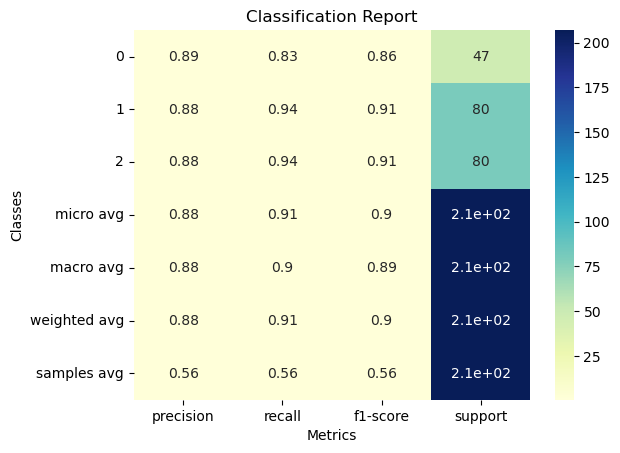

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Assuming you already have the true labels (y_test) and predicted labels (y_pred)

# Generate the classification report
report = classification_report(y_test, y_pred)

# Create a heatmap visualization
sns.heatmap(pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T, annot=True, cmap="YlGnBu")

# Add labels, title, and formatting
plt.xlabel("Metrics")
plt.ylabel("Classes")
plt.title("Classification Report")
plt.show()


In [20]:
from sklearn.model_selection import train_test_split

# Assuming you have your feature data in X and target data in y

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the split datasets
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)


X_train shape: (811, 7)
y_train shape: (811, 3)
X_val shape: (203, 7)
y_val shape: (203, 3)


In [31]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import OneHotEncoder

# Assuming you have your features in X_train and X_val,
# and your target variable in y_train and y_val

# Calculate the number of unique classes
num_classes = np.unique(y_train).shape[0]

# Encode the target variable using one-hot encoding
encoder = OneHotEncoder(sparse=False, categories='auto')
y_train_encoded = encoder.fit_transform(y_train.reshape(811,7))
y_val_encoded = encoder.transform(y_val.reshape(203,7))

# Create the neural network model
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(7,)))
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train_encoded, batch_size=64, epochs=50, validation_data=(X_val, y_val_encoded))


AttributeError: 'DataFrame' object has no attribute 'reshape'

In [28]:
import numpy as np
from keras.utils import to_categorical

# Assuming you have your target variable in y_train and y_val

# Calculate the number of unique classes
num_classes = np.unique(y_train).shape[0]

# One-hot encode the target variables
y_train_encoded = to_categorical(y_train, num_classes)
y_val_encoded = to_categorical(y_val, num_classes)

print(num_classes)


2


In [87]:
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.layers import Dropout
# from tensorflow.keras.layers import Dense
# from tensorflow.keras import regularizers


# # Create your neural network model
# model = keras.Sequential([
#     layers.Dense(128, activation='relu', input_shape=(7,)),
#     layers.BatchNormalization(),
#     layers.Dropout(0.5),
#     layers.Dense(64, activation='relu'),
#     layers.BatchNormalization(),
#     layers.Dropout(0.1),
#     layers.Dense(3, activation='softmax')
# ])


# # Define the optimizer with an initial learning rate
# optimizer = Adam(learning_rate=0.01)

# # Compile the model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# # Train the model
# history = model.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_val, y_val))


In [88]:

# Add a Dense layer with L2 regularization (lambda=0.01)
model.add(Dense(3, activation='relu', kernel_regularizer=regularizers.l2(0.01)))

In [89]:

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [91]:
# # Train the model
# history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val))

In [93]:
# from tensorflow.keras.callbacks import EarlyStopping

# # Create an EarlyStopping callback
# early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# # Train the model with early stopping
# model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[early_stopping])


this one is preliminary.  wo9rk with tyhe one aboce.  commented out for easier scrolling 

In [94]:
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# from tensorflow.keras.optimizers import Adam



# # Define the model architecture
# model = keras.Sequential([
#     layers.Dense(64, activation='relu', input_shape=(7,)),
#     layers.Dense(64, activation='relu'),
#     layers.Dense(3, activation='softmax')
# ])

# # Define the optimizer with an initial learning rate
# optimizer = Adam(learning_rate=0.0001)

# # Compile the model
# model.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

# # Train the model
# model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))

# # Evaluate the model
# loss, accuracy = model.evaluate(X_test, y_test)

# # Make predictions
# predictions = model.predict(X_test)


In [66]:
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# from tensorflow.keras.optimizers import Adam



# # Define the model architecture
# model = keras.Sequential([
#     layers.Dense(64, activation='relu', input_shape=(7,)),
#     layers.Dense(64, activation='relu'),
#     layers.Dense(3, activation='softmax')
# ])

# # Define the optimizer with an initial learning rate
# optimizer = Adam(learning_rate=0.1)

# # Compile the model
# model.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

# # Train the model
# model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))

# # Evaluate the model
# loss, accuracy = model.evaluate(X_test, y_test)

# # Make predictions
# predictions = model.predict(X_test)


In [102]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD

# Generate random training data
X_train = np.random.random((1000, 10))
y_train = np.random.randint(2, size=(1000, 1))

# Define the model
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=10))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=SGD(learning_rate=0.005), loss='binary_crossentropy', metrics=['accuracy'])

# Set batch size and number of epochs
batch_size = 32
epochs = 10

# Perform mini-batch gradient descent
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs)


Epoch 1/10
32/32 [==============================] - 1s 2ms/step - loss: 0.6970 - accuracy: 0.4710
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.6965 - accuracy: 0.4740
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.6962 - accuracy: 0.4870
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.6959 - accuracy: 0.4900
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.6955 - accuracy: 0.5070
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.6952 - accuracy: 0.5050
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.6951 - accuracy: 0.4980
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.6950 - accuracy: 0.4890
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.6948 - accuracy: 0.4990
Epoch 10/10
32/32 [==============================] - 0s 2ms/step - loss: 0.6946 - accuracy: 0.4940
